In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.load_data import LoadData
from sklearn.metrics import confusion_matrix

### previous ground truth

In [17]:
# the ground truth values
load_data = LoadData()
data = load_data.data

old_demanda_2024 = data.loc[data['year'] == 2024][['year','month','day','crossed_threshold','consumo_max_diario',]]
old_demanda_2024['datetime'] = pd.to_datetime(old_demanda_2024[['year','month','day']])
old_demanda_2024 = old_demanda_2024.set_index('datetime')
old_demanda_2024.drop(columns=['year','month','day'], inplace=True)
old_demanda_2024.rename(columns={'crossed_threshold':'estouro de demanda', 'consumo_max_diario':'demanda (MWh)'}, inplace=True)
display(old_demanda_2024)
display(old_demanda_2024['estouro de demanda'].value_counts())

Data lost:  31


,estouro de demanda,demanda (MWh)
datetime,,
2024-01-01,0,6.357671
2024-01-02,0,6.353846
2024-01-03,0,6.790784
2024-01-04,0,7.210391
2024-01-05,0,7.028001
...,...,...
2024-03-27,1,8.834712
2024-03-28,1,8.683421
2024-03-29,1,9.024435


estouro de demanda
0    77
1    14
Name: count, dtype: int64

### ground truth

In [8]:
# the ground truth values
path = 'results/ground_truth_data/ground_truth.csv'
data = pd.read_csv(path)
data = data.set_index('datetime')
data.index = pd.to_datetime(data.index)
demanda_2024 = data.rename(columns={'estouro':'estouro de demanda', 'consumo_mwh':'demanda (MWh)'})
display(demanda_2024)
display(demanda_2024['estouro de demanda'].value_counts())

,demanda (MWh),estouro de demanda
datetime,,
2024-01-01,6.294,0
2024-01-02,6.342,0
2024-01-03,6.778,0
2024-01-04,7.197,0
2024-01-05,7.015,0
...,...,...
2024-09-15,8.001,0
2024-09-16,7.675,0
2024-09-17,7.173,0


estouro de demanda
0    210
1     53
Name: count, dtype: int64

In [21]:
demanda_2024_filtered = demanda_2024[demanda_2024.index <= '2024-03-31']
display(demanda_2024_filtered['estouro de demanda'].value_counts())

estouro de demanda
0    77
1    14
Name: count, dtype: int64

Show results function 

In [26]:
def plot_confusion_matrix(y_test, y_pred, model_name):
    sns.set_theme(style="darkgrid")
    fig, ax = plt.subplots(figsize=(10, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)
    ax.set_title(f'Confusion Matrix - {model_name}')
    plt.plot()

In [9]:
def apply_threshold(probabilities, threshold):
    return (probabilities >= threshold).astype(int)

In [29]:
def show_df_results(model_name, new_threshold=None): 
    prediction_data_path = f'results/output_data/{model_name}.csv'
    prediction_data = pd.read_csv(prediction_data_path)
    prediction_data.index = pd.to_datetime(prediction_data['datetime'])
    prediction_data.drop(columns=['datetime'], inplace=True)
    prediction_data = prediction_data[['probabilidade_de_estouro', 'estouro_previsto']]

    print("Prediction data")
    display(prediction_data)

    results_df = pd.merge(prediction_data, demanda_2024, how='inner', left_index=True, right_index=True)

    if new_threshold:
        results_df['estouro_previsto'] = apply_threshold(results_df['probabilidade_de_estouro'], new_threshold)
        print(f"New threshold: {new_threshold}")

    print("Results data")
    display(results_df)
   

    false_negative_error_df =results_df[(results_df['estouro_previsto'] == 0) & (results_df['estouro de demanda'] == 1)]
    print(f'False negative error: {len(false_negative_error_df)} days of {len(results_df[results_df["estouro de demanda"] == 1])} days')
    display(false_negative_error_df)


    false_positive_error_df =results_df[(results_df['estouro_previsto'] == 1) & (results_df['estouro de demanda'] == 0)]
    print(f'False positive error: {len(false_positive_error_df)} days of {len(results_df[results_df["estouro de demanda"] == 0])} days')
    display(false_positive_error_df)

    TP = len(results_df[(results_df["estouro_previsto"] == 1) & (results_df["estouro de demanda"] == 1)]) 
    TN = len(results_df[(results_df["estouro_previsto"] == 0) & (results_df["estouro de demanda"] == 0)])
    FP = len(results_df[(results_df["estouro_previsto"] == 1) & (results_df["estouro de demanda"] == 0)])
    FN = len(results_df[(results_df["estouro_previsto"] == 0) & (results_df["estouro de demanda"] == 1)])

    plot_confusion_matrix(results_df["estouro de demanda"], results_df["estouro_previsto"], model_name)

    print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN)}')
    print(f'Precision: {TP / (TP + FP)}')
    print(f'Recall: {TP / (TP + FN)}')
    print(f'F1 Score: {2 * (TP / (TP + FP) * TP / (TP + FN)) / (TP / (TP + FP) + TP / (TP + FN))}')
    


# Xgboost

Prediction data


,probabilidade_de_estouro,estouro_previsto
datetime,,
2024-01-01,0.005157,0
2024-01-02,0.004496,0
2024-01-03,0.006817,0
2024-01-04,0.004897,0
2024-01-05,0.006186,0
...,...,...
2024-12-27,0.940286,1
2024-12-28,0.905265,1
2024-12-29,0.839121,1


Results data


,probabilidade_de_estouro,estouro_previsto,demanda (MWh),estouro de demanda
datetime,,,,
2024-01-01,0.005157,0,6.294,0
2024-01-02,0.004496,0,6.342,0
2024-01-03,0.006817,0,6.778,0
2024-01-04,0.004897,0,7.197,0
2024-01-05,0.006186,0,7.015,0
...,...,...,...,...
2024-09-15,0.088094,0,8.001,0
2024-09-16,0.107086,0,7.675,0
2024-09-17,0.107086,0,7.173,0


False negative error: 11 days of 53 days


,probabilidade_de_estouro,estouro_previsto,demanda (MWh),estouro de demanda
datetime,,,,
2024-03-11,0.026346,0,8.639,1
2024-03-13,0.205438,0,8.522,1
2024-03-14,0.092298,0,8.867,1
2024-03-15,0.092298,0,8.749,1
2024-03-24,0.203780,0,8.732,1
2024-03-25,0.007916,0,8.663,1
2024-03-26,0.009029,0,9.131,1
2024-06-06,0.036427,0,8.315,1
2024-07-16,0.017714,0,8.411,1


False positive error: 8 days of 210 days


,probabilidade_de_estouro,estouro_previsto,demanda (MWh),estouro de demanda
datetime,,,,
2024-04-10,0.987829,1,8.249,0
2024-04-13,0.989356,1,8.292,0
2024-04-19,0.989852,1,8.147,0
2024-04-20,0.989356,1,7.937,0
2024-04-21,0.988138,1,7.995,0
2024-05-02,0.989034,1,8.036,0
2024-05-03,0.976124,1,7.877,0
2024-05-12,0.988138,1,8.073,0


None

Accuracy: 0.9277566539923955
Precision: 0.84
Recall: 0.7924528301886793
F1 Score: 0.8155339805825242


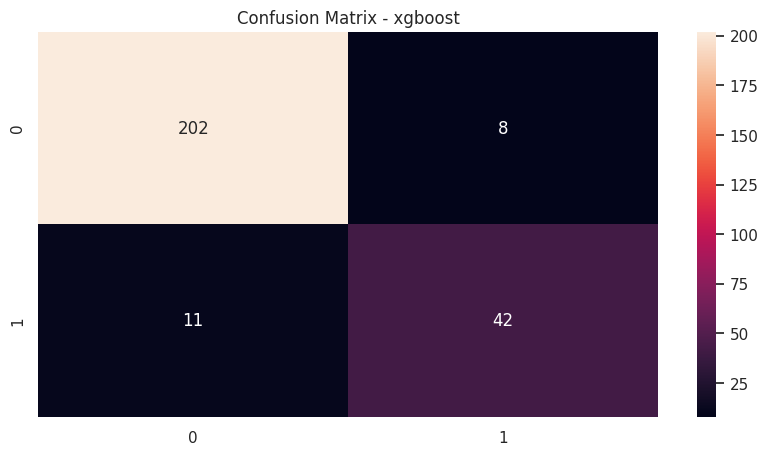

In [30]:
show_df_results('xgboost')

Xgboost v2

Prediction data


,probabilidade_de_estouro,estouro_previsto
datetime,,
2024-01-01,0.005157,0
2024-01-02,0.004496,0
2024-01-03,0.006817,0
2024-01-04,0.004897,0
2024-01-05,0.006186,0
...,...,...
2024-12-27,0.940286,1
2024-12-28,0.905265,1
2024-12-29,0.839121,1


New threshold: 0.2
Results data


,probabilidade_de_estouro,estouro_previsto,demanda (MWh),estouro de demanda
datetime,,,,
2024-01-01,0.005157,0,6.294,0
2024-01-02,0.004496,0,6.342,0
2024-01-03,0.006817,0,6.778,0
2024-01-04,0.004897,0,7.197,0
2024-01-05,0.006186,0,7.015,0
...,...,...,...,...
2024-09-15,0.088094,0,8.001,0
2024-09-16,0.107086,0,7.675,0
2024-09-17,0.107086,0,7.173,0


False negative error: 9 days of 53 days


,probabilidade_de_estouro,estouro_previsto,demanda (MWh),estouro de demanda
datetime,,,,
2024-03-11,0.026346,0,8.639,1
2024-03-14,0.092298,0,8.867,1
2024-03-15,0.092298,0,8.749,1
2024-03-25,0.007916,0,8.663,1
2024-03-26,0.009029,0,9.131,1
2024-06-06,0.036427,0,8.315,1
2024-07-16,0.017714,0,8.411,1
2024-09-09,0.107086,0,8.365,1
2024-09-13,0.107426,0,8.385,1


False positive error: 20 days of 210 days


,probabilidade_de_estouro,estouro_previsto,demanda (MWh),estouro de demanda
datetime,,,,
2024-04-10,0.987829,1,8.249,0
2024-04-13,0.989356,1,8.292,0
2024-04-19,0.989852,1,8.147,0
2024-04-20,0.989356,1,7.937,0
2024-04-21,0.988138,1,7.995,0
2024-05-02,0.989034,1,8.036,0
2024-05-03,0.976124,1,7.877,0
2024-05-12,0.988138,1,8.073,0
2024-05-14,0.230325,1,8.137,0


None

Accuracy: 0.8897338403041825
Precision: 0.6875
Recall: 0.8301886792452831
F1 Score: 0.7521367521367521


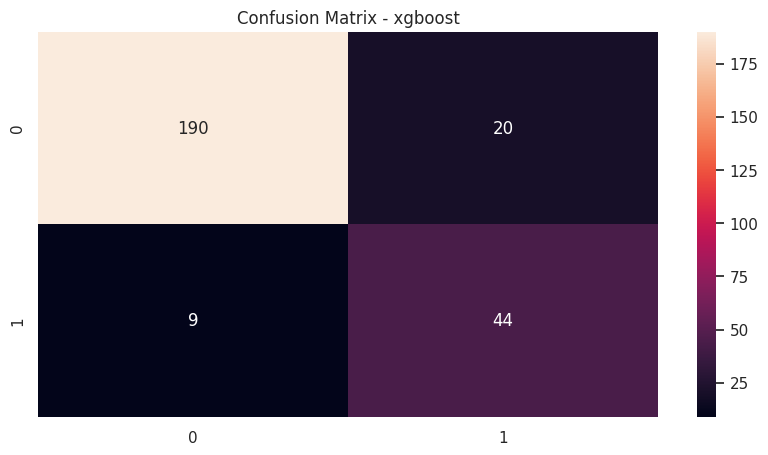

In [37]:
# testing xgboost to compare with the best previous model
show_df_results('xgboost', new_threshold=0.2)

### Random Forest

Prediction data


,probabilidade_de_estouro,estouro_previsto
datetime,,
2024-01-01,0.008,0
2024-01-02,0.010,0
2024-01-03,0.004,0
2024-01-04,0.004,0
2024-01-05,0.022,0
...,...,...
2024-12-27,0.138,0
2024-12-28,0.098,0
2024-12-29,0.112,0


Results data


,probabilidade_de_estouro,estouro_previsto,demanda (MWh),estouro de demanda
datetime,,,,
2024-01-01,0.008,0,6.294,0
2024-01-02,0.010,0,6.342,0
2024-01-03,0.004,0,6.778,0
2024-01-04,0.004,0,7.197,0
2024-01-05,0.022,0,7.015,0
...,...,...,...,...
2024-09-15,0.048,0,8.001,0
2024-09-16,0.034,0,7.675,0
2024-09-17,0.044,0,7.173,0


False negative error: 31 days of 53 days


,probabilidade_de_estouro,estouro_previsto,demanda (MWh),estouro de demanda
datetime,,,,
2024-03-11,0.296,0,8.639,1
2024-03-14,0.200,0,8.867,1
2024-03-15,0.396,0,8.749,1
2024-03-24,0.198,0,8.732,1
2024-03-25,0.122,0,8.663,1
2024-03-26,0.230,0,9.131,1
2024-04-04,0.496,0,8.922,1
2024-04-12,0.494,0,8.713,1
2024-04-14,0.432,0,8.419,1


False positive error: 1 days of 210 days


,probabilidade_de_estouro,estouro_previsto,demanda (MWh),estouro de demanda
datetime,,,,
2024-04-10,0.662,1,8.249,0


None

Accuracy: 0.8783269961977186
Precision: 0.9565217391304348
Recall: 0.41509433962264153
F1 Score: 0.5789473684210525


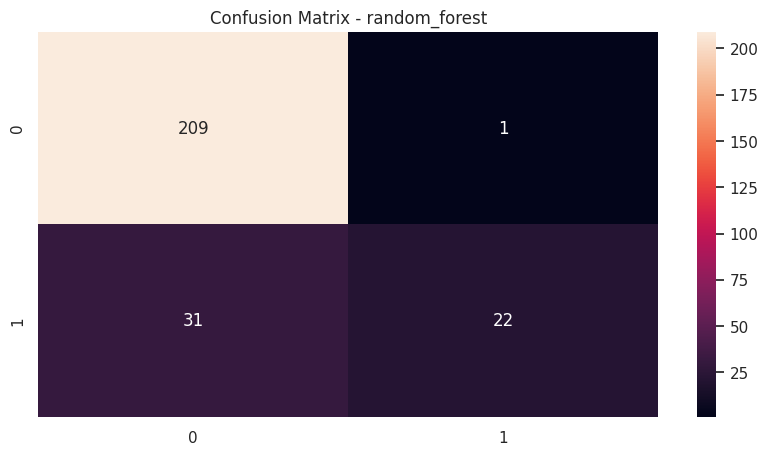

In [38]:
show_df_results('random_forest')

Random Forest v2

Prediction data


,probabilidade_de_estouro,estouro_previsto
datetime,,
2024-01-01,0.008,0
2024-01-02,0.010,0
2024-01-03,0.004,0
2024-01-04,0.004,0
2024-01-05,0.022,0
...,...,...
2024-12-27,0.138,0
2024-12-28,0.098,0
2024-12-29,0.112,0


New threshold: 0.4
Results data


,probabilidade_de_estouro,estouro_previsto,demanda (MWh),estouro de demanda
datetime,,,,
2024-01-01,0.008,0,6.294,0
2024-01-02,0.010,0,6.342,0
2024-01-03,0.004,0,6.778,0
2024-01-04,0.004,0,7.197,0
2024-01-05,0.022,0,7.015,0
...,...,...,...,...
2024-09-15,0.048,0,8.001,0
2024-09-16,0.034,0,7.675,0
2024-09-17,0.044,0,7.173,0


False negative error: 10 days of 53 days


,probabilidade_de_estouro,estouro_previsto,demanda (MWh),estouro de demanda
datetime,,,,
2024-03-11,0.296,0,8.639,1
2024-03-14,0.200,0,8.867,1
2024-03-15,0.396,0,8.749,1
2024-03-24,0.198,0,8.732,1
2024-03-25,0.122,0,8.663,1
2024-03-26,0.230,0,9.131,1
2024-06-06,0.014,0,8.315,1
2024-07-16,0.040,0,8.411,1
2024-09-09,0.034,0,8.365,1


False positive error: 7 days of 210 days


,probabilidade_de_estouro,estouro_previsto,demanda (MWh),estouro de demanda
datetime,,,,
2024-04-10,0.662,1,8.249,0
2024-04-13,0.428,1,8.292,0
2024-04-19,0.422,1,8.147,0
2024-04-21,0.434,1,7.995,0
2024-05-02,0.466,1,8.036,0
2024-05-03,0.434,1,7.877,0
2024-05-12,0.462,1,8.073,0


None

Accuracy: 0.935361216730038
Precision: 0.86
Recall: 0.8113207547169812
F1 Score: 0.8349514563106796


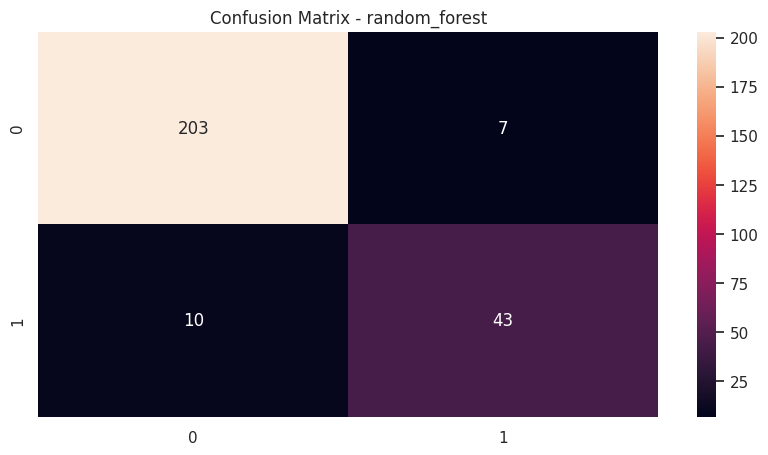

In [40]:
show_df_results('random_forest', new_threshold=0.4)

KNN